# 🔬 Congestion Control Simulator – Interactive Demo

Single-seed experiments comparing **DCTCP vs Reno** in:
1. **Data Center** – low RTT (0.1 ms), shallow buffers
2. **Space DC** – high RTT (200 ms), jitter, outages

Run all cells top-to-bottom to produce inline plots.

## 1. Install Dependencies & Imports

In [1]:
%pip install numpy matplotlib seaborn pandas pyyaml -q


[notice] A new release of pip is available: 25.2 -> 26.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
import sys, os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import yaml

%matplotlib inline
sns.set_theme(style="whitegrid", font_scale=1.1)

# Import simulator (ensure we're in the repo root)
from sim_core import Flow, Switch, Simulator, PKT_BYTES, LINK_RATE_BYTES_PER_MS
print("✓ All imports OK")

✓ All imports OK


## 2. Load Configurations

Load DC and Space configs from YAML files (or use inline defaults).

In [3]:
# DC config
dc_cfg = dict(
    rtt_base_ms=0.1, buffer_pkts=300, ecn_thresh_pkts=30,
    dt_ms=0.1, duration_ms=5000.0,
    long_flows_per_cc=5, short_lambda=5.0, short_size_bytes=10240,
)

# Space config
space_cfg = dict(
    rtt_base_ms=200.0, buffer_pkts=300, ecn_thresh_pkts=30,
    dt_ms=0.1, duration_ms=5000.0,
    num_long_flows=10, short_lambda=3.0, short_size_bytes=10240,
    rtt_jitter_std_ms=50.0, outage_prob_per_sec=0.1, outage_duration_ms=1000.0,
)

# Try loading from YAML files if available
for name, cfg_dict in [("dc", dc_cfg), ("space", space_cfg)]:
    path = f"configs/{name}_config.yaml"
    if os.path.exists(path):
        with open(path) as f:
            cfg_dict.update(yaml.safe_load(f))
        print(f"✓ Loaded {path}")

print(f"DC  RTT = {dc_cfg['rtt_base_ms']} ms,  buffer = {dc_cfg['buffer_pkts']} pkts, duration = {dc_cfg['duration_ms']} ms")
print(f"Space RTT = {space_cfg['rtt_base_ms']} ms, jitter σ = {space_cfg.get('rtt_jitter_std_ms', 0)} ms")

✓ Loaded configs/dc_config.yaml
✓ Loaded configs/space_config.yaml
DC  RTT = 0.1 ms,  buffer = 300 pkts, duration = 5000.0 ms
Space RTT = 200.0 ms, jitter σ = 50.0 ms


## 3. Run Data Center Experiment (Single Seed)

5 Reno + 5 DCTCP long flows, Poisson short flows (100 KB), RTT = 0.1 ms.

In [4]:
SEED = 42
rng = np.random.default_rng(SEED)
sw = Switch(buffer_pkts=dc_cfg["buffer_pkts"], ecn_thresh_pkts=dc_cfg["ecn_thresh_pkts"])
dc_sim = Simulator(dt_ms=dc_cfg["dt_ms"], duration_ms=dc_cfg["duration_ms"], switch=sw, rng=rng)

# Add 5 Reno + 5 DCTCP long flows
fid = 0
for cc in ("reno", "dctcp"):
    for _ in range(dc_cfg["long_flows_per_cc"]):
        dc_sim.add_flow(Flow(fid, cc, rtt_base_ms=dc_cfg["rtt_base_ms"]))
        fid += 1

# Poisson short flows
for cc in ("reno", "dctcp"):
    dc_sim.schedule_short_flows(
        lam_per_sec=dc_cfg["short_lambda"],
        size_bytes=dc_cfg["short_size_bytes"],
        cc=cc, rtt_base_ms=dc_cfg["rtt_base_ms"],
    )

dc_metrics, dc_fcts = dc_sim.run()
print(f"✓ DC experiment done: {len(dc_metrics)} time-steps, {len(dc_fcts)} short flows completed")

✓ DC experiment done: 50000 time-steps, 60 short flows completed


## 4. Run Space DC Experiment (Single Seed)

10 flows per CC variant (Reno / DCTCP / SpaceCC), RTT = 200 ms + jitter, with outage epochs.

In [5]:
space_results = {}  # cc -> (metrics, fcts)

for cc in ("reno", "dctcp", "spacecc"):
    rng = np.random.default_rng(SEED)
    sw = Switch(buffer_pkts=space_cfg["buffer_pkts"], ecn_thresh_pkts=space_cfg["ecn_thresh_pkts"])
    sim = Simulator(dt_ms=space_cfg["dt_ms"], duration_ms=space_cfg["duration_ms"], switch=sw, rng=rng)
    sim.outage_prob = space_cfg.get("outage_prob_per_sec", 0.1)
    sim.outage_duration_ms = space_cfg.get("outage_duration_ms", 1000.0)
    sim.rtt_jitter_std_ms = space_cfg.get("rtt_jitter_std_ms", 50.0)

    for fid in range(space_cfg["num_long_flows"]):
        sim.add_flow(Flow(fid, cc, rtt_base_ms=space_cfg["rtt_base_ms"]))
    sim.schedule_short_flows(
        lam_per_sec=space_cfg["short_lambda"],
        size_bytes=space_cfg["short_size_bytes"],
        cc=cc, rtt_base_ms=space_cfg["rtt_base_ms"],
    )
    metrics, fcts = sim.run()
    space_results[cc] = (metrics, fcts)
    print(f"  [{cc}] {len(metrics)} steps, {len(fcts)} short flows")

print("✓ Space experiment done")

  [reno] 50000 steps, 10 short flows
  [dctcp] 50000 steps, 11 short flows
  [spacecc] 50000 steps, 10 short flows
✓ Space experiment done


## 5. Plot Queue Delay Over Time (DC)

Time-series of the **shared bottleneck** queue with 5 Reno + 5 DCTCP flows competing.
DCTCP's ECN-driven response keeps the aggregate queue oscillations tighter than pure Reno would.

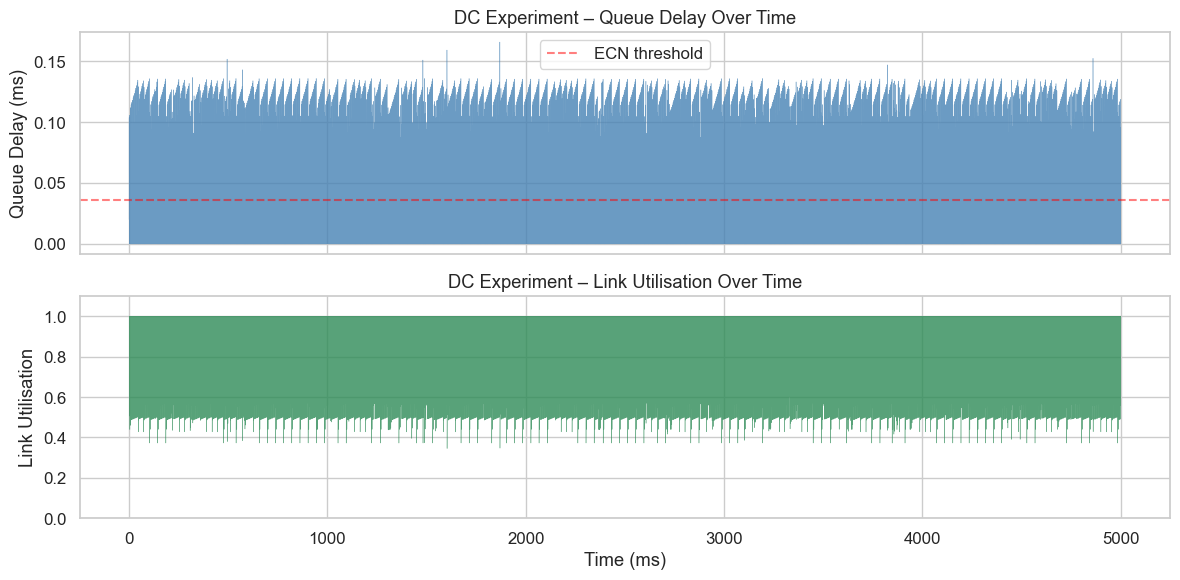

Mean queue delay: 0.0313 ms
p99  queue delay: 0.1295 ms
Mean utilisation: 0.861


In [6]:
times = [m.time_ms for m in dc_metrics]
delays = [m.queue_delay_ms for m in dc_metrics]
utils = [m.util for m in dc_metrics]

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 6), sharex=True)

# Queue delay
ax1.plot(times, delays, linewidth=0.3, alpha=0.8, color="steelblue")
ax1.set_ylabel("Queue Delay (ms)")
ax1.set_title("DC Experiment – Queue Delay Over Time")
ax1.axhline(y=dc_cfg["ecn_thresh_pkts"] * PKT_BYTES / LINK_RATE_BYTES_PER_MS,
            color="red", linestyle="--", alpha=0.5, label="ECN threshold")
ax1.legend()

# Utilisation
ax2.plot(times, utils, linewidth=0.3, alpha=0.8, color="seagreen")
ax2.set_ylabel("Link Utilisation")
ax2.set_xlabel("Time (ms)")
ax2.set_title("DC Experiment – Link Utilisation Over Time")
ax2.set_ylim(0, 1.1)

plt.tight_layout()
plt.show()

print(f"Mean queue delay: {np.mean(delays):.4f} ms")
print(f"p99  queue delay: {np.percentile(delays, 99):.4f} ms")
print(f"Mean utilisation: {np.mean(utils):.3f}")

## 6. Queue Delay CDF – DC vs Space

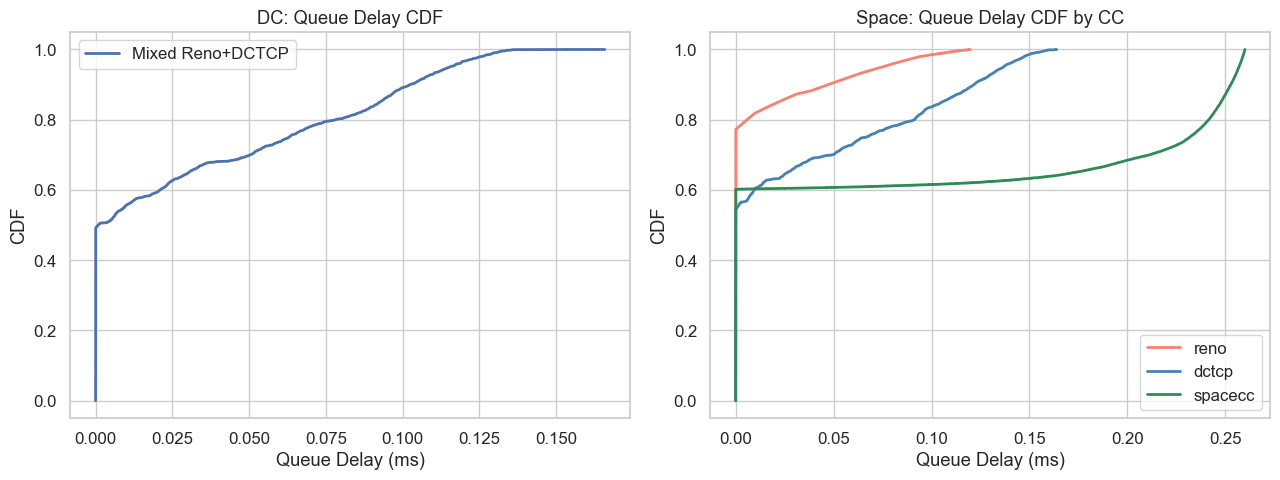

In [7]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 5))

# DC CDF
dc_delays = np.array([m.queue_delay_ms for m in dc_metrics])
sorted_d = np.sort(dc_delays)
cdf = np.arange(1, len(sorted_d) + 1) / len(sorted_d)
ax1.step(sorted_d, cdf, linewidth=2, label="Mixed Reno+DCTCP")
ax1.set_xlabel("Queue Delay (ms)")
ax1.set_ylabel("CDF")
ax1.set_title("DC: Queue Delay CDF")
ax1.legend()

# Space CDF (per CC)
colors = {"reno": "salmon", "dctcp": "steelblue", "spacecc": "seagreen"}
for cc, (metrics, _) in space_results.items():
    d = np.sort([m.queue_delay_ms for m in metrics])
    c = np.arange(1, len(d) + 1) / len(d)
    ax2.step(d, c, linewidth=2, label=cc, color=colors[cc])
ax2.set_xlabel("Queue Delay (ms)")
ax2.set_ylabel("CDF")
ax2.set_title("Space: Queue Delay CDF by CC")
ax2.legend()

plt.tight_layout()
plt.show()

## 7. Utilisation Boxplots – Space DC per CC

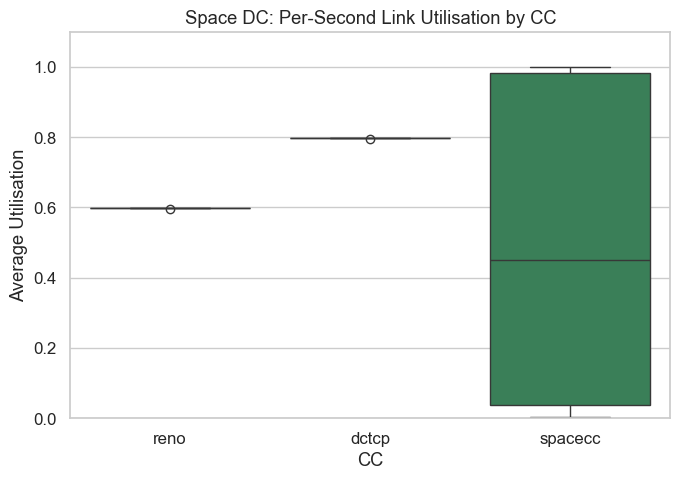

In [8]:
# Build DataFrame of per-second average utilisation for space experiment
util_rows = []
for cc, (metrics, _) in space_results.items():
    # bucket into 1-second windows
    window_ms = 1000.0
    t_arr = np.array([m.time_ms for m in metrics])
    u_arr = np.array([m.util for m in metrics])
    for start in np.arange(0, t_arr[-1], window_ms):
        mask = (t_arr >= start) & (t_arr < start + window_ms)
        if mask.any():
            util_rows.append({"CC": cc, "Avg Util": float(np.mean(u_arr[mask]))})

util_df = pd.DataFrame(util_rows)

fig, ax = plt.subplots(figsize=(7, 5))
sns.boxplot(x="CC", y="Avg Util", data=util_df, hue="CC", palette=colors, legend=False, ax=ax)
ax.set_ylim(0, 1.1)
ax.set_title("Space DC: Per-Second Link Utilisation by CC")
ax.set_ylabel("Average Utilisation")
plt.tight_layout()
plt.show()

## 8. Short-Flow FCT Comparison

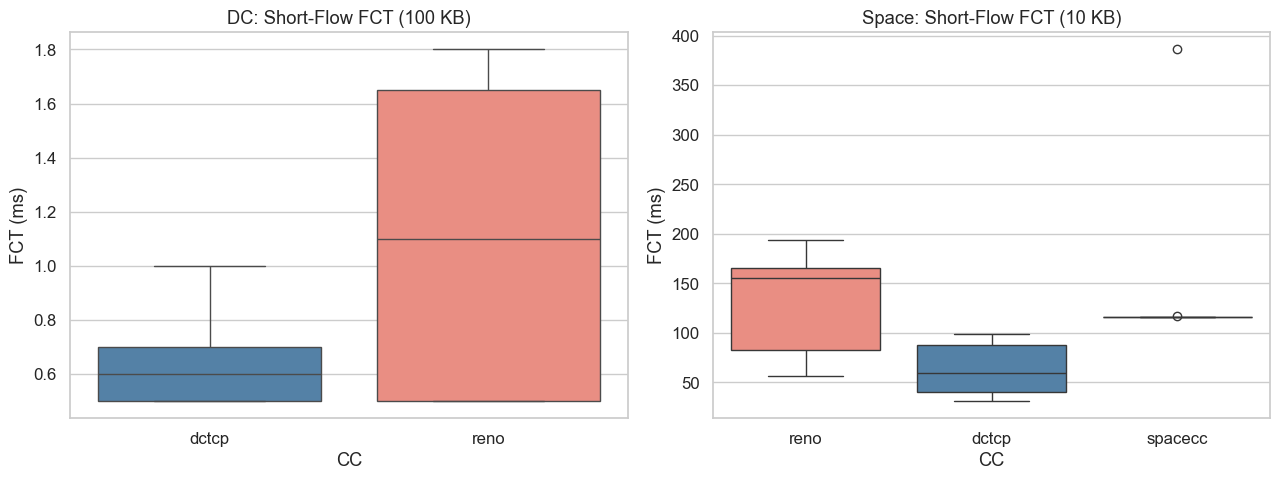

── FCT p99 Summary ──
  DC     dctcp     p99 = 1.00 ms  (n=37)
  DC     reno      p99 = 1.80 ms  (n=23)
  Space  dctcp     p99 = 98.57 ms  (n=11)
  Space  reno      p99 = 191.55 ms  (n=10)
  Space  spacecc   p99 = 361.68 ms  (n=10)


In [9]:
# DC FCTs
fct_data = []
for f in dc_fcts:
    fct_data.append({"Scenario": "DC", "CC": f.cc, "FCT (ms)": f.fct_ms})

# Space FCTs
for cc, (_, fcts) in space_results.items():
    for f in fcts:
        fct_data.append({"Scenario": "Space", "CC": cc, "FCT (ms)": f.fct_ms})

fct_df = pd.DataFrame(fct_data)

if len(fct_df):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 5))

    dc_fct_df = fct_df[fct_df["Scenario"] == "DC"]
    if len(dc_fct_df):
        sns.boxplot(x="CC", y="FCT (ms)", data=dc_fct_df, hue="CC",
                    palette={"reno": "salmon", "dctcp": "steelblue"}, legend=False, ax=ax1)
    ax1.set_title(f"DC: Short-Flow FCT ({dc_cfg['short_size_bytes']//1024} KB)")

    sp_fct_df = fct_df[fct_df["Scenario"] == "Space"]
    if len(sp_fct_df):
        sns.boxplot(x="CC", y="FCT (ms)", data=sp_fct_df, hue="CC", palette=colors, legend=False, ax=ax2)
    ax2.set_title(f"Space: Short-Flow FCT ({space_cfg['short_size_bytes']//1024} KB)")

    plt.tight_layout()
    plt.show()

    # Print p99 summary
    print("── FCT p99 Summary ──")
    for (sc, cc), grp in fct_df.groupby(["Scenario", "CC"]):
        print(f"  {sc:6s} {cc:8s}  p99 = {grp['FCT (ms)'].quantile(0.99):.2f} ms  (n={len(grp)})")
else:
    print("No short flows completed – try a longer duration.")

## 9. Combined Dashboard – DC vs Space

2×3 composite figure: queue delay time-series, utilisation, FCT distributions.

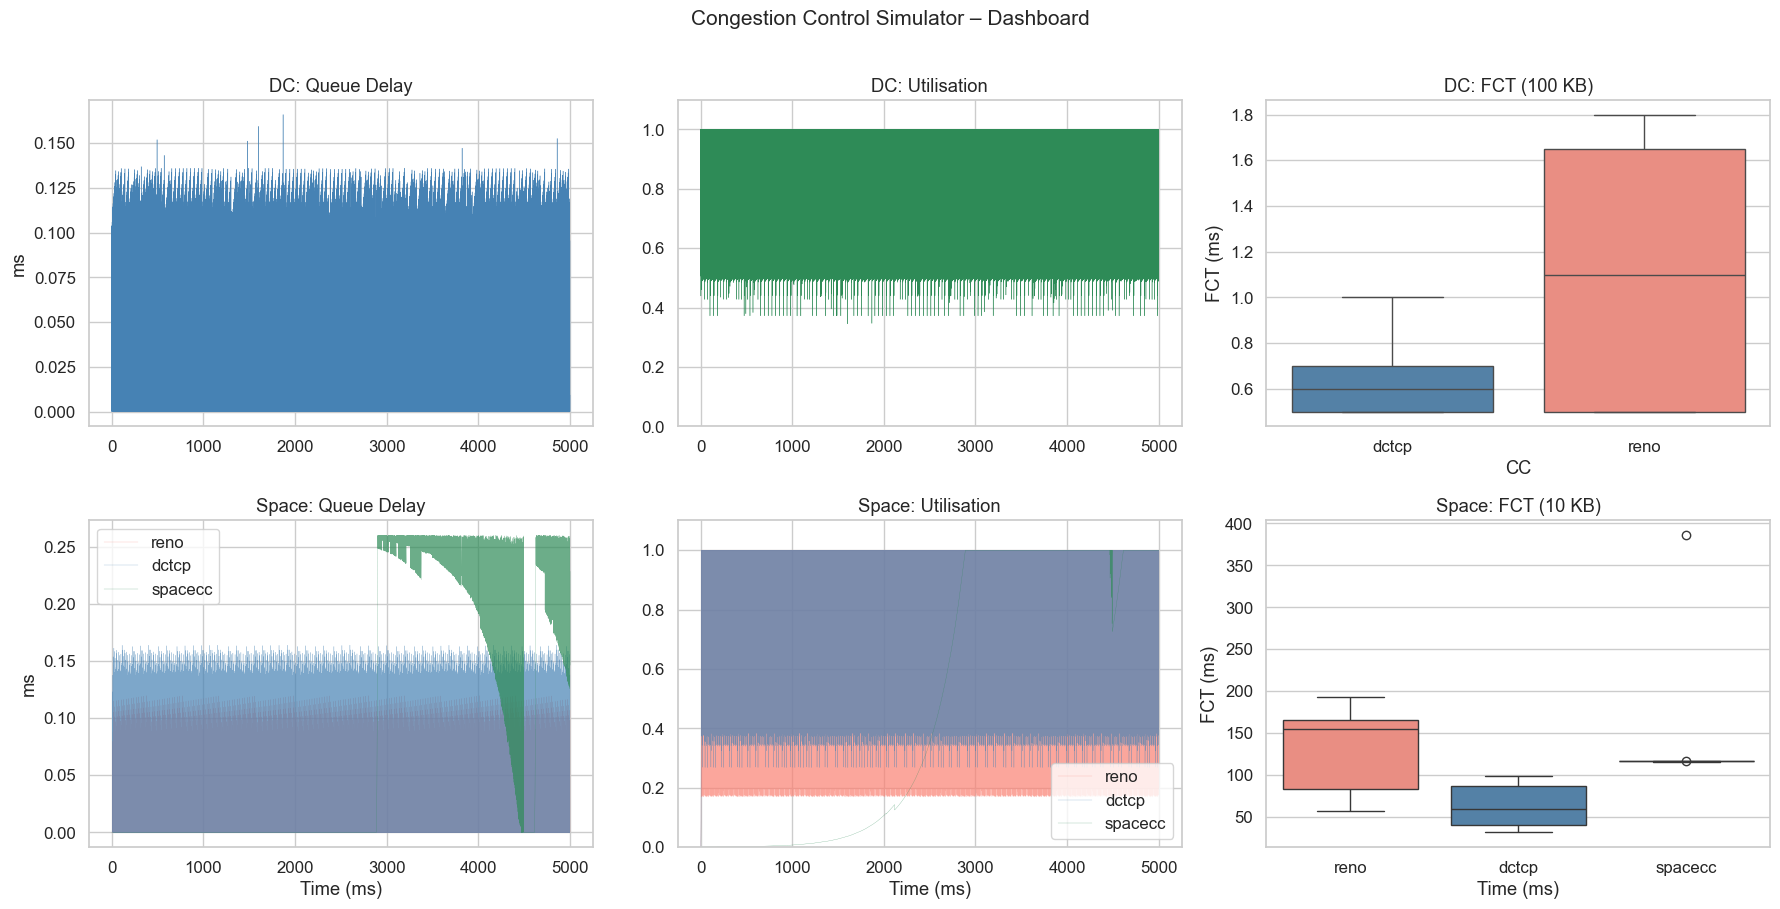

✓ Saved results/demo_dashboard.png


In [10]:
fig, axes = plt.subplots(2, 3, figsize=(18, 9))

# ── Row 0: DC ──
dc_t = [m.time_ms for m in dc_metrics]
dc_d = [m.queue_delay_ms for m in dc_metrics]
dc_u = [m.util for m in dc_metrics]
axes[0, 0].plot(dc_t, dc_d, lw=0.3, color="steelblue")
axes[0, 0].set_title("DC: Queue Delay"); axes[0, 0].set_ylabel("ms")

axes[0, 1].plot(dc_t, dc_u, lw=0.3, color="seagreen")
axes[0, 1].set_title("DC: Utilisation"); axes[0, 1].set_ylim(0, 1.1)

dc_fct_sub = fct_df[fct_df["Scenario"] == "DC"]
if len(dc_fct_sub):
    sns.boxplot(x="CC", y="FCT (ms)", data=dc_fct_sub, hue="CC",
                palette={"reno": "salmon", "dctcp": "steelblue"}, legend=False, ax=axes[0, 2])
axes[0, 2].set_title(f"DC: FCT ({dc_cfg['short_size_bytes']//1024} KB)")

# ── Row 1: Space ──
for cc, color in colors.items():
    m_list = space_results[cc][0]
    t = [m.time_ms for m in m_list]
    d = [m.queue_delay_ms for m in m_list]
    u = [m.util for m in m_list]
    axes[1, 0].plot(t, d, lw=0.2, alpha=0.7, label=cc, color=color)
    axes[1, 1].plot(t, u, lw=0.2, alpha=0.7, label=cc, color=color)

axes[1, 0].set_title("Space: Queue Delay"); axes[1, 0].set_ylabel("ms"); axes[1, 0].legend()
axes[1, 1].set_title("Space: Utilisation"); axes[1, 1].set_ylim(0, 1.1); axes[1, 1].legend()

sp_fct_sub = fct_df[fct_df["Scenario"] == "Space"]
if len(sp_fct_sub):
    sns.boxplot(x="CC", y="FCT (ms)", data=sp_fct_sub, hue="CC", palette=colors, legend=False, ax=axes[1, 2])
axes[1, 2].set_title(f"Space: FCT ({space_cfg['short_size_bytes']//1024} KB)")

for ax in axes[1, :]:
    ax.set_xlabel("Time (ms)")

fig.suptitle("Congestion Control Simulator – Dashboard", fontsize=15, y=1.01)
plt.tight_layout()
os.makedirs("results", exist_ok=True)
fig.savefig("results/demo_dashboard.png", dpi=150, bbox_inches="tight")
plt.show()
print("✓ Saved results/demo_dashboard.png")

## 10. 🧪 SpaceCC – Delay-Based Algorithm for High-RTT Links

`sim_core.py` already ships a working **SpaceCC** implementation that uses
EWMA-smoothed RTT ratio as its congestion signal.  The cell below shows how
to monkey-patch an alternative version for quick experimentation.

In [11]:
# ── Current SpaceCC algorithm (mirrors sim_core.py) ──
# EWMA-smoothed RTT ratio: detects congestion without jitter false-positives.
# Increase is scaled per-RTT (~doubling when uncongested).

def my_spacecc_update(self, rtt_ms, queue_ms, ecn_frac, loss):
    """
    Delay-based CC for high-RTT space links.
    - EWMA smooth factor 0.9/0.1 filters jitter noise
    - Ratio > 1.25 → multiplicative decrease (halve cwnd)
    - Otherwise    → aggressive ramp-up scaled per RTT
    """
    if self.rtt_smooth == 0:
        self.rtt_smooth = rtt_ms
    else:
        self.rtt_smooth = 0.9 * self.rtt_smooth + 0.1 * rtt_ms
    rtt_ratio = self.rtt_smooth / max(self.rtt_base_ms, 0.01)
    if rtt_ratio > 1.25:
        self.cwnd = max(self.cwnd * 0.5, 2)
    else:
        self.cwnd += self.cwnd * 0.5 * (0.1 / max(rtt_ms, 0.1))

# Patch it in for testing (re-run Section 4 to see the effect)
Flow._spacecc_update = my_spacecc_update
print("✓ SpaceCC patched – re-run Section 4 to test!")

✓ SpaceCC patched – re-run Section 4 to test!
